In [1]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git 
!pip install opencv-python
!pip install plot_keras_history

  Cloning https://www.github.com/keras-team/keras-contrib.git to c:\users\husey\appdata\local\temp\pip-req-build-lcoiqldq
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101669 sha256=07feaf14c333b6b4c600557f671698b9e4d4ae9ab7a548c38e1b58b5b2469479
  Stored in directory: C:\Users\husey\AppData\Local\Temp\pip-ephem-wheel-cache-bzy5w6r9\wheels\67\d2\f4\96ae3c3c62d1e05abfc8860ad0c1207794726d44ebbbb547f3
Successfully built keras-contrib


In [74]:
import datetime
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers  import Activation, Conv2D, Input, Dropout, LeakyReLU, Input, Dense, Concatenate, Conv2DTranspose, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization 
from random import random, randint
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

In [132]:
def discriminatorModel(imageShape):
    init = RandomNormal(stddev=0.02)
    inputImage = Input(shape=imageShape)
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputImage)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    LOut = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    model = Model(inputImage, LOut)
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model
model = discriminatorModel((256,256,3))    
model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_299 (Conv2D)          (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_70 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_300 (Conv2D)          (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization_310 ( (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_71 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_301 (Conv2D)          (None, 32, 32, 256)       524

In [133]:
def residualBlock(LNumberofFilters, LInputLayer):
    init = RandomNormal(stddev=0.02)
    resTensor = Conv2D(LNumberofFilters, (3,3), padding='same', kernel_initializer=init)(LInputLayer)
    resTensor =InstanceNormalization(axis=-1)(resTensor)
    resTensor = Activation('relu')(resTensor)
    resTensor = Conv2D(LNumberofFilters, (3,3), padding='same', kernel_initializer=init)(resTensor)
    resTensor =InstanceNormalization(axis=-1)(resTensor)
    resTensor = Concatenate()([resTensor, LInputLayer])
    return resTensor

In [134]:
def generatorModel(LImageShape, LResnet=9):
    init = RandomNormal(stddev=0.02)
    LInputShape = Input(shape=LImageShape)
    genTensor = Conv2D(64, (7,7), padding = 'same', kernel_initializer=init)(LInputShape)
    genTensor = InstanceNormalization(axis=-1)(genTensor)
    genTensor = Activation('relu')(genTensor)
    genTensor = Conv2D(128, (3,3), strides = (2,2), padding = 'same', kernel_initializer=init)(genTensor)
    genTensor = InstanceNormalization(axis=-1)(genTensor)
    genTensor = Activation('relu')(genTensor)
    genTensor = Conv2D(258, (3,3), strides = (2,2), padding = 'same', kernel_initializer=init)(genTensor)
    genTensor = InstanceNormalization(axis=-1)(genTensor)
    genTensor = Activation('relu')(genTensor)
    
    for _ in range(LResnet):
        genTensor = residualBlock(256, genTensor)
    
    genTensor = Conv2DTranspose(128, (3,3), strides = (2,2), padding = 'same', kernel_initializer=init)(genTensor)
    genTensor = InstanceNormalization(axis=-1)(genTensor)
    genTensor = Conv2DTranspose(64, (3,3), strides = (2,2), padding = 'same', kernel_initializer=init)(genTensor)
    genTensor = InstanceNormalization(axis=-1)(genTensor)
    genTensor = Conv2D(3, (7,7), padding='same', activation='tanh', kernel_initializer=init)(genTensor)
    genTensor = InstanceNormalization(axis=-1)(genTensor)
    
    LOutImage = Activation('tanh')(genTensor)
    model = Model(LInputShape, LOutImage)
    return model

model = generatorModel((256,256,3)) 
model.summary()  

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_305 (Conv2D)             (None, 256, 256, 64) 9472        input_42[0][0]                   
__________________________________________________________________________________________________
instance_normalization_314 (Ins (None, 256, 256, 64) 128         conv2d_305[0][0]                 
__________________________________________________________________________________________________
activation_130 (Activation)     (None, 256, 256, 64) 0           instance_normalization_314[0][0] 
___________________________________________________________________________________________

In [135]:
def compositeModel(generatorModel1, discriminatorModel, generatorModel2, imageShape):
    generatorModel1.trainable = True
    discriminatorModel.trainable = False
    generatorModel2.trainable = False

    InputGenerator = Input(shape=imageShape)
    generatorModel1Out = generatorModel1(InputGenerator)
    output_d = discriminatorModel(generatorModel1Out)

    input_id = Input(shape=imageShape)
    output_id = generatorModel1(input_id)

    output_f = generatorModel2(generatorModel1Out)
    generatorModel2Out = generatorModel2(input_id)
    output_b = generatorModel1(generatorModel2Out)

    model = Model([InputGenerator, input_id], [output_d, output_id, output_f, output_b])
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model

In [136]:
imageShape = (256,256,3)
generatorModelAtoB = generatorModel(imageShape)
generatorModelBtoA = generatorModel(imageShape)
discriminatorModelA = discriminatorModel(imageShape)
discriminatorModelB = discriminatorModel(imageShape)
compositeModelAtoB = compositeModel(generatorModelAtoB, discriminatorModelB, generatorModelBtoA, imageShape)
compositeModelBtoA = compositeModel(generatorModelBtoA, discriminatorModelA, generatorModelAtoB, imageShape)

In [137]:
def generateRealSamples(dataset, LSamples, patchShape):
    ix = np.random.randint(0, dataset.shape[0], LSamples)
    X = dataset[ix]
    y = np.ones((LSamples, patchShape, patchShape, 1))
    return X, y

In [138]:
def generateFakeSamples(generatorModel, dataset, patchShape):
    X = generatorModel.predict(dataset)
    y = np.zeros((len(X), patchShape, patchShape, 1))
    return X, y

In [139]:
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            # use image, but don't add it to the pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = randint(0, len(pool) - 1)
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)

In [147]:
def train(discriminatorModelA, discriminatorModelB, generatormodelAtoB, generatormodelBtoA, 
          compositeModelAtoB, compositeModelBtoA, trainA, trainB):
    LEpochs, LBatch = 100, 1
    LPatch = discriminatorModelA.output_shape[1]
    LBatchPerEpoch = int(len(trainA) / LBatch)
    #LSteps = LBatchPerEpoch * LEpochs
    LSteps = 10
    LPoolA, LPoolB = list(), list()
    dA1_hist, dB1_hist, dA2_hist, dB2_hist, g1_hist, g2_hist = list(), list(), list(), list(), list(), list()
    for i in range(LSteps):
        start = datetime.datetime.now()
        X_realA, y_realA = generateRealSamples(trainA, LBatch, LPatch)
        X_realB, y_realB = generateRealSamples(trainB, LBatch, LPatch)

        print("Generated Real Samples")
        X_fakeA, y_fakeA = generateFakeSamples(generatormodelBtoA, X_realB, LPatch)
        X_fakeB, y_fakeB = generateFakeSamples(generatormodelAtoB, X_realA, LPatch)

        
        print("Generated Fake Samples")
        X_fakeA = update_image_pool(LPoolA, X_fakeA)
        X_fakeB = update_image_pool(LPoolB, X_fakeB)
        print("Updated Image Pool")

        
        gloss2, _, _, _, _  = compositeModelBtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        
        dAloss1 = discriminatorModelA.train_on_batch(X_realA, y_realA)
        dAloss2 = discriminatorModelA.train_on_batch(X_fakeA, y_fakeA)
        
        gloss1, _, _, _, _ = compositeModelAtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        print("Calculated Generator Loss")
        
        dBloss1 = discriminatorModelA.train_on_batch(X_realB, y_realB)
        dBloss2 = discriminatorModelB.train_on_batch(X_fakeB, y_fakeB)
        print("Calculated Discriminator Loss")
        
        dA1_hist.append(dAloss1)
        dB1_hist.append(dBloss1)
        dA2_hist.append(dAloss2)
        dB2_hist.append(dBloss2)
        g1_hist.append(gloss1)
        g2_hist.append(gloss2)
        print(gloss1,gloss2)
        
        end = datetime.datetime.now()
        print(end-start)
        print("Epochs:"+str(i))
        print("Finished")
        filename_g_model_AtoB = "generator_model_g_model_AtoB_%03d.h5" % (LSteps + 1)
        filename_d_model_B = "generator_model_d_model_B_%03d.h5" % (LSteps + 1)

        generatormodelAtoB.compile(optimizer=Adam(lr=0.0002, beta_1=0.5),
                      metrics=['accuracy'])

        generatormodelAtoB.save(filename_g_model_AtoB)
        discriminatorModelB.save(filename_d_model_B)

In [141]:
import cv2
import os

trainA = []
dataset_path = 'images/trainA'
for filename in os.listdir(dataset_path):
    img = cv2.imread(os.path.join(dataset_path, filename))
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    trainA.append(img)

trainB = []
dataset_path = 'images/trainB'
for filename in os.listdir(dataset_path):
    img = cv2.imread(os.path.join(dataset_path, filename))
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    trainB.append(img)

testA = []
dataset_path = 'images/testA'
for filename in os.listdir(dataset_path):
    img = cv2.imread(os.path.join(dataset_path, filename))
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    testA.append(img)

testB = []
dataset_path = 'images/testB'
for filename in os.listdir(dataset_path):
    img = cv2.imread(os.path.join(dataset_path, filename))
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    testB.append(img)

trainA = np.array(trainA)
trainB = np.array(trainB)
testA = np.array(testA)
testB = np.array(testB)

In [148]:
train(discriminatorModelA, discriminatorModelB, generatorModelAtoB, generatorModelBtoA, 
      compositeModelAtoB, compositeModelBtoA, trainA, trainB)

Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
27.208118438720703 20.343852996826172
0:02:14.522064
Epochs:0
Finished
Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
27.830013275146484 19.582298278808594
0:02:16.374047
Epochs:1
Finished
Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
22.208168029785156 18.592113494873047
0:02:16.549931
Epochs:2
Finished
Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
21.36075782775879 19.089977264404297
0:02:17.039914
Epochs:3
Finished
Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
20.843881607055664 18.675769805908203
0:02:15.985396
Epochs:4
Finished
Generated Real Samples
Generated Fake Sam

In [143]:
from keras.models import load_model
from keras.preprocessing.image import load_img,  img_to_array
from numpy import load, expand_dims
import keras_contrib
import matplotlib.pyplot as plt

In [144]:
def load_image(filename, size=(256,256)):
    pixels = load_img(filename, target_size=size)
    pixels = img_to_array(pixels)
    pixels = cv2.normalize(pixels, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    pixels = expand_dims(pixels, 0)
    return pixels

In [151]:
src_image = load_image('images/testB/2014-10-02 20_08_58.jpg')
print('Loaded', src_image.shape)
model = load_model('generator_model_g_model_AtoB_006.h5', custom_objects={'InstanceNormalization':keras_contrib.layers.InstanceNormalization})
gen_image = model.predict(src_image)
gen_image = (gen_image + 1) / 2.0
model2 = load_model('generator_model_g_model_AtoB_011.h5', custom_objects={'InstanceNormalization':keras_contrib.layers.InstanceNormalization})
gen_image2 = model2.predict(src_image)
gen_image2 = (gen_image2 + 1) / 2.0

Loaded (1, 256, 256, 3)


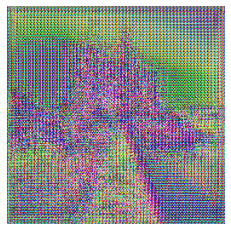

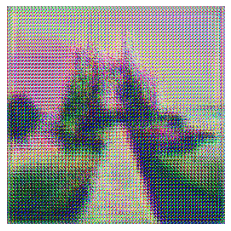

In [152]:
# plot the image
plt.imshow(gen_image[0])
plt.axis('off')
plt.show()
# plot the image
plt.imshow(gen_image2[0])
plt.axis('off')
plt.show()